#Demo of EKF vs UKF

This demonstrates the UKF's capacity to approximate the target distribution that results from a non-linear transformation with greater accuracy than the EKF. This is because while the EKF approximates the distribution locally at the mean, the UKF utilizes the distribution of the $2n+1$ sigma points to more accurately capture the global distribution.

Example adapted from Figures 5.3, 5.4, and 5.5 of Simo Särkkä (2013), “Bayesian Filtering and Smoothing."

Simo Särkkä (2013), “Bayesian Filtering and Smoothing,” Cambridge University Press. Available: https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf

Demo by Peter G. Chang ([@petergchang](https://github.com/petergchang))

##0. Imports

In [ ]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [ ]:
# https://github.com/probml/probml-utils/blob/main/probml_utils/plotting.py\n",
try:
    import probml_utils as pml
except ModuleNotFoundError:
    print('installing probml_utils')
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

In [ ]:
try:
    from ssm_jax.plotting import plot_ellipse
    import ssm_jax.ukf.inference as ukf
except ModuleNotFoundError:
    print('installing ssm_jax')
    %pip install -qq git+https://github.com/probml/ssm-jax.git
    from ssm_jax.plotting import plot_ellipse
    import ssm_jax.ukf.inference as ukf

In [ ]:
import matplotlib.pyplot as plt

import jax.random as jr
import jax.numpy as jnp
from jax import vmap
from jax import jacfwd

##1. Helper Functions

In [ ]:
def generate_2d_gaussian(mean, cov, num_samples=1000, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    return jr.multivariate_normal(key, mean, cov, shape=(num_samples,))

In [ ]:
def plot_data(points, ax=None, xlim=(-4, 4), ylim=(-4, 4), **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(*points.T, "ok", ms=1, **kwargs)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    x_d, y_d = xlim[1] - xlim[0], ylim[1] - ylim[0]
    ax.set_xticks(jnp.arange(int(xlim[0]), xlim[1]+0.1, x_d // 4))
    ax.set_yticks(jnp.arange(int(ylim[0]), ylim[1]+0.1, y_d // 4))
    ax.set_aspect((xlim[1]-xlim[0])/(ylim[1]-ylim[0]))
    return ax

In [ ]:
def compute_moments(points):
    x, y = points.T
    mu = (jnp.mean(x), jnp.mean(y))
    cov = jnp.cov(x, y)
    return mu, cov

In [ ]:
def plot_stats(points, ax, n_std=2.0, **kwargs):
    mean, cov = compute_moments(points)
    # Add circle around mean
    ax.plot(*mean, 'ok', fillstyle='none', ms=12, mew=2.5)
    # Add confidence ellipse
    plot_ellipse(cov, mean, ax, n_std=n_std, **kwargs);
    return ax

In [ ]:
def plot_sigmas(ax, sigmas, n_std=2.0, **kwargs):
    ax.plot(*sigmas.T, 'ok', fillstyle='none', ms=12, mew=2.5)
    return ax

##2. Demonstration

First, we generate a 2d Gaussian dataset comprising of 1,000 random samples around (0, 0). This replicates Figure 5.3(a) of Särkkä.

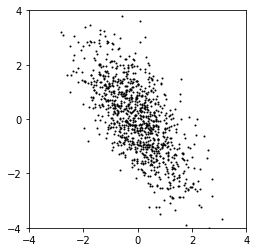

In [ ]:
# Gaussian moments
mean_pre = jnp.array([0., 0.])
cov_pre = jnp.array([[1., -1.], [-1, 2.]])

points = generate_2d_gaussian(mean_pre, cov_pre)
plot_data(points);

We can examine the mean and covariance of the Gaussian random samples, as in Figure 5.4(a) of Särkkä.

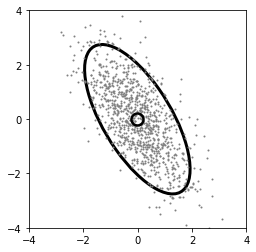

In [ ]:
ax = plot_data(points, color='gray')
plot_stats(points, ax, lw=3);

Next, we define some non-linear transformation to be applied to the points. This is a variation on Figure 5.3(b) of Särkkä.

In [ ]:
def non_linear_transform(point):
    x = point[0]**2 + point[1]**2
    y = jnp.sin(jnp.cos(point[0])-jnp.sin(point[1]))
    return jnp.array([x, y])

In [ ]:
def non_linear_transform(point):
    x = jnp.sin(point[0] - point[1])
    y = point[1]
    return jnp.array([x, y])

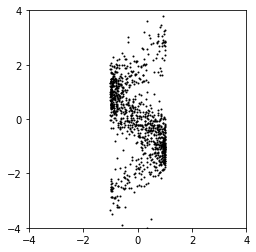

In [ ]:
transformed_points = vmap(non_linear_transform)(points)
plot_data(transformed_points);

We compare the EKF approximation to the transformation (solid line) to the true distribution (dashed line), as in Figure 5.4(b) of Särkkä.

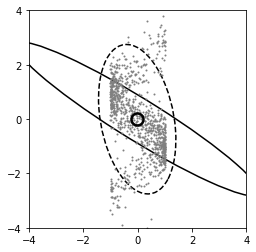

In [ ]:
def extended_transform(f, mean, cov):
    F = jacfwd(f)(mean)
    return f(mean), F @ cov @ F.T

ekf_mean, ekf_cov = extended_transform(non_linear_transform, mean_pre, cov_pre)

ax = plot_data(transformed_points, color='gray')
plot_stats(transformed_points, ax, ls='--', lw=1.5);
plot_ellipse(ekf_cov, ekf_mean, ax, n_std=2.0, lw=1.5);

Next, we turn our attention to UKF. The sigma points on the initial distribution are computed as the following (similar to Figure 5.5(a) of Särkkä).

In [ ]:
# Set hyperparameters to default values
hyperparams = ukf.UKFHyperParams(alpha=0.5)
alpha, beta, kappa = hyperparams.alpha, hyperparams.beta, hyperparams.kappa

# Compute sigma points
state_dim = cov_pre.shape[0]
lamb = ukf._compute_lambda(alpha, kappa, state_dim)
sigmas = ukf._compute_sigmas(mean_pre, cov_pre, state_dim, lamb)

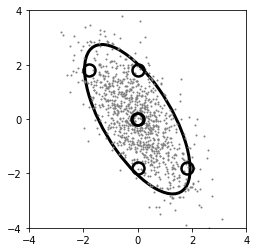

In [ ]:
ax = plot_data(points, color='gray')
plot_stats(points, ax, lw=3);
plot_sigmas(ax, sigmas);

We use the unscented transform to propagate the sigma points using the non-linear function, and compute the covariance (solid line) which closely approximates the real covariance (dashed line) (similar to Figure 5.5(b) of Särkkä).

In [ ]:
# Propagate the sigma points
sigmas_prop = vmap(non_linear_transform)(sigmas)

# Compute weights for unscented transform
w_mean, w_cov = ukf._compute_weights(state_dim, alpha, beta, lamb)

# Compute the covariance using propagated sigma points
ukf_mean = jnp.tensordot(w_mean, sigmas_prop, axes=1)
ukf_cov = jnp.tensordot(w_cov, ukf._outer(sigmas_prop - ukf_mean, sigmas_prop - ukf_mean), axes=1)

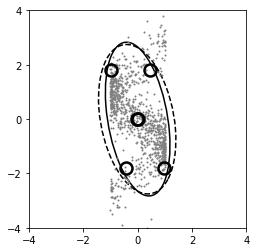

In [ ]:
ax = plot_data(transformed_points, color='gray')
plot_stats(transformed_points, ax, ls='--', lw=1.5);
plot_sigmas(ax, sigmas_prop);
plot_ellipse(ukf_cov, ukf_mean, ax, n_std=2.0, lw=1.5);